<a href="https://colab.research.google.com/github/Sharath-a26/Adversarial-Learning/blob/main/Deep_Convolutional_GAN_with_FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
with ZipFile("drive/MyDrive/lc25000.zip") as zObject:
  zObject.extractall("dataset")

In [ ]:
import os
colon_folder = "dataset/lung_colon_image_set/colon_image_sets/colon_n"
for i in os.listdir(colon_folder):
  os.remove(colon_folder + "/" + i)
os.rmdir(colon_folder)

In [ ]:
lung_folder = "dataset/lung_colon_image_set/lung_image_sets/lung_n"
for i in os.listdir(lung_folder):
  os.remove(lung_folder + "/" + i)
os.rmdir(lung_folder)

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow

In [ ]:
import tensorflow.keras as keras
dataset = keras.utils.image_dataset_from_directory(
    "dataset",image_size = (64,64),batch_size=32, label_mode=None
)

Found 15000 files.


## Rescaling the dataset in range 0-1

In [ ]:
dataset = dataset.map(lambda x:x/255.0)

###Sample Image

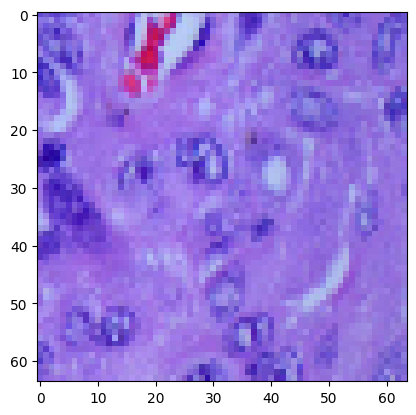

In [ ]:
import matplotlib.pyplot as plt
for i in dataset:
  plt.imshow((i.numpy() * 255).astype("int32")[0])
  break

##Discriminator/

In [ ]:
from keras import layers
disc = keras.Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(negative_slope=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

In [ ]:
disc.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

##Generator

In [ ]:
input_latent_dim = 128

gen = keras.Sequential(
    [
        keras.Input(shape=(input_latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ]

)


In [ ]:
gen.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

## GAN Training

In [ ]:
import random

def random_rotation(latent_vector):
    angle = random.uniform(-0.2, 0.2)
    return latent_vector * (1 + angle)

def random_translation(latent_vector):

    translation_factor = random.uniform(-0.2, 0.2)
    return latent_vector + translation_factor

def random_scaling(latent_vector):

    scaling_factor = random.uniform(0.8, 1.2)
    return latent_vector * scaling_factor

def random_noise(latent_vector):
    noise_factor = tf.random.normal(shape=tf.shape(latent_vector), mean=0.0, stddev=0.1)
    return latent_vector + noise_factor


def augment_latent_vector(latent_vector):
    latent_vector = random_rotation(latent_vector)
    latent_vector = random_translation(latent_vector)
    latent_vector = random_scaling(latent_vector)
    latent_vector = random_noise(latent_vector)
    return latent_vector


## FGSM Attack Function

In [ ]:
def fgsm_attack(image, epsilon, gradient):

    signed_grad = tf.sign(gradient)

    adversarial_image = image + epsilon * signed_grad

    #making it in the range 0-1
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image

In [ ]:
from tqdm import tqdm
import tensorflow as tf
for epoch in range(10):
  for index, real in enumerate(tqdm(dataset)):
    batch_size = real.shape[0]

    random_latent_vectors = tf.random.normal(shape = (batch_size, input_latent_dim))

    augmented_latent_vectors = tf.map_fn(augment_latent_vector, random_latent_vectors)


    fake = gen(augmented_latent_vectors)


    with tf.GradientTape() as disc_tape:


      loss_disc_real = loss_fn(tf.ones(batch_size,1),disc(real))
      loss_disc_fake = loss_fn(tf.zeros(batch_size,1),disc(fake))
      total_disc_loss = (loss_disc_real + loss_disc_fake)/2

    gradients = disc_tape.gradient(total_disc_loss, disc.trainable_weights)

    opt_disc.apply_gradients(
        zip(gradients, disc.trainable_weights)
    )

    with tf.GradientTape() as gen_tape:
      # gen_tape.watch(random_latent_vectors)
      fake = gen(random_latent_vectors)
      output = disc(fake)
      loss_gen = loss_fn(tf.ones(batch_size,1),output)

    grad = gen_tape.gradient(loss_gen, random_latent_vectors)

    epsilon = 0.1  # attack strength

    # getting the sign of the gradient and changing latent vector using fgsm
    perturbed_latent_vector = random_latent_vectors + epsilon * tf.sign(grad)

    perturbed_latent = tf.stop_gradient(perturbed_latent_vector)

    with tf.GradientTape() as final_gen_tape:
      fake_adv = gen(perturbed_latent)
      output = disc(fake_adv)
      loss_gen = loss_fn(tf.ones((batch_size, 1)), output)



    gradients2 = final_gen_tape.gradient(loss_gen, gen.trainable_weights)

    opt_gen.apply_gradients(
        zip(gradients2, gen.trainable_weights)
    )

  1%|          | 4/469 [00:12<24:52,  3.21s/it]


KeyboardInterrupt: 

In [ ]:
gen.save("/content/drive/My Drive/gen_with_fgsm_epoch_10.h5")

## Image Generation

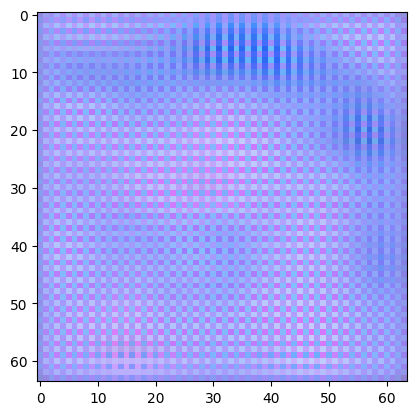

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_noise = tf.random.normal(shape = (5,input_latent_dim))
generated_images = gen(random_noise, training=False)

generated_images = generated_images.numpy()


img = generated_images[4]

img = (img*255).astype(np.uint8)

plt.imshow(img)

## Importing the model saved before

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
gen_model = load_model('/content/drive/My Drive/gen_with_fgsm_epoch_10.h5')

(64, 64, 3)


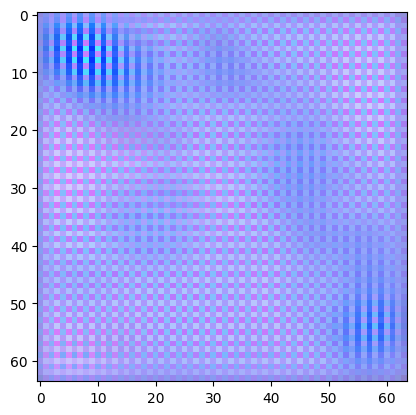

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_noise = tf.random.normal(shape = (5,input_latent_dim))
generated_images = gen_model(random_noise, training=False)

generated_images = generated_images.numpy()


img = generated_images[4]

img = (img*255).astype(np.uint8)

print(np.shape(img))
plt.imshow(img)

# Creating a classifier to identify adversarial/original image

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (64,64)
BATCH_SIZE = 32



In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    'dataset',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


Found 12000 images belonging to 1 classes.


In [ ]:
from tensorflow.keras import layers, models

def image_classifier(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
cnn = image_classifier(IMG_SIZE + (3,))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
EPOCHS = 5
cnn.fit(train_generator, epochs=EPOCHS)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 105ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 1.0000 - loss: 0.0000e+00


In [ ]:
# Generating adverarial images using FGSM for training the classifier

def generate_adversarial_images(model, images, labels, epsilon):
  loss_function = tf.keras.losses.CategoricalCrossentropy()
  images = tf.convert_to_tensor(images)
  with tf.GradientTape() as tape:
    tape.watch(images)
    pred = model(images)
    loss = loss_function(labels, pred)
  gradient = tape.gradient(loss,images)
  perturbations = epsilon * tf.sign(gradient)
  adversarial_image = images + perturbations

  # clipping the image pixel values between 0 and 1
  return tf.clip_by_value(adversarial_image, 0, 1)

In [ ]:
x_clean, y_clean = next(train_generator)
x_adv = generate_adversarial_images(cnn, x_clean, y_clean, 0.02)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(32, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


In [ ]:
x_combined = np.concatenate([x_clean, x_adv])

In [ ]:
# 0 class for original images and 1 for adversarial images
y_combined = np.concatenate([np.zeros(len(x_clean)), np.ones(len(x_adv))])

In [ ]:
def adversarial_image_classifier(input_shape):
  model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
split = int(0.8 * len(x_combined))

In [ ]:
x_train, x_test = x_combined[:split], x_combined[split:]
y_train, y_test = y_combined[:split], y_combined[split:]

In [ ]:
adversarial_classifier = adversarial_image_classifier(IMG_SIZE + (3,))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
adversarial_classifier.fit(x_train, y_train, epochs=1000, validation_split=0.1)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7241 - loss: 0.5575 - val_accuracy: 0.0000e+00 - val_loss: 1.4217
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7032 - loss: 0.5728 - val_accuracy: 0.0000e+00 - val_loss: 1.4244
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7137 - loss: 0.5572 - val_accuracy: 0.0000e+00 - val_loss: 1.5497
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6928 - loss: 0.5739 - val_accuracy: 0.0000e+00 - val_loss: 1.6664
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6928 - loss: 0.5654 - val_accuracy: 0.0000e+00 - val_loss: 1.8706
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7137 - loss: 0.5550 - val_accuracy: 0.0000e+00 - val_loss: 1.7216
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7241 - loss: 0.5254 - val_accuracy: 0.0000e+00 - val_loss: 1.3985
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7137 - loss: 0.548